# Calder Lenhart
## ASTRON 3350 Final Project - Computational Notebook


#### Project Description
In this computational notebook, I analyze the line profiles of atomic species in KELT-20b's transmission spectrum. I've integrated this project with my research outside of class.

My workflow thus far has been:
1. Import the spectral data
2. Correct of sources of noise in the data
3. Generate model spectra for atomic species in the atmosphere.
4. Cross-correlate observed spectra with model spectra for all potential atomic/molecular species in the atmosphere -- noting tentative or definite detections (4-sigma and 5-sigma respectively).
5. Correct for the Rossiter-McLaughlin effect.
6. __For detected species, analyze their variations within the atmosphere over the course of transit.__

I've worked on the first five steps previously, although the fifth step is still in progress. The last step is what I intend to do for this final project, doing exploratory data analysis on the line profiles of detected species within the atmosphere. These line profiles are roughly gaussian curves, and I intend to apply a gaussian and/or multi-gaussian fit to them to analyze important properties such as their mean (wind velocity), standard deviation (broadening), amplitude (can correspond to the mechanism in the atmosphere causing them), FWHM, residuals, etc. Using plots of SNR (of the cross-correlations between model and observed spectra) vs phase and residuals (between phase curve and fit) vs phase, I can gather a wealth of information about the underlying dynamics of the atmosphere. This work is essential to my research, and I believe that tying it all in with this class would be perfect, as most of the techniques and analysis we have learned in this class will directly apply. Additionally, many of these visualizations can be employed when presenting my poster at the AAS meeting in January.

__Goals__
1. Generate line profiles + residuals for all species that I've detected and tentatively detected thus far
2. Make gaussian or multi-gaussian fits for each species
3. Analyze the derived parameters, describe all important takeaways for each species, investigate any unexpected outcomes
4. Investigate and quantitatively conclude which mechanisms are behind the wind velocities for each species, using Savel et al. as a reference [1].

__Data__
- Spectra of KELT-20/KELT-20b obtained by PEPSI on LBT
- Model spectra generated by petitRADTRANS

__References__
[1] Savel, A. B., Kempton, E. M. R., Rauscher, E., Komacek, T. D., Bean, J. L., Malik, M., & Malsky, I. (2023). Diagnosing Limb Asymmetries in Hot and Ultrahot Jupiters with High-resolution Transmission Spectroscopy. The Astrophysical Journal, 944(1), 99.


# Generate line profiles + residuals for all species detected and tentatively detected thus far

#### Imports
First, I have to import a bunch of packages necessary to run these precursor functions. Please note that this project is based off some prewritten code for research. My project will largely concern the exploratory data anaylsis aspect of the research. I will submit all of the modules alongside this Jupyter Notebook.

In [9]:
# Imports
import numpy as np
import matplotlib.pyplot as pl
import matplotlib.gridspec as gridspec

from glob import glob
from astropy.io import fits

from scipy.stats import chisquare
from scipy.optimize import curve_fit

from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation
import astropy.units as u
from astropy.table import Table

from uncertainties import ufloat
from uncertainties import unumpy as unp

from atmo_utilities import ccf, one_log_likelihood, log_likelihood_CCF, vacuum2air, log_likelihood_opt_beta

import time

from dtutils import psarr

#from radiant import generate_atmospheric_model, get_wavelength_range

from create_model import create_model, instantiate_radtrans
import horus

from run_all_ccfs import *

%matplotlib inline

First, I'll define a gaussian function to fit to the line profile.

In [10]:
def gaussian(x, a, mu, sigma):

    '''
    Inputs:
    x: x values
    a: amplitude
    mu: mean
    sigma: standard deviation

    Output:
    Gaussian function
    '''
    return a * np.exp(-(x - mu)**2 / (2 * sigma**2))


### Preexisting Cross-Correlation Function Plot

I've imported a png of the CCF plot for neutral iron (Fe) in KELT-20b's atmosphere with both the red and blue arms of the PEPSI spectrograph combined. The x-axis is the velocity shift in km/s, and the y-axis is the SNR of the cross-correlation. The peak of the cross-correlation function is the velocity shift of the line profile. The SNR is a measure of the significance of the detection. The higher the SNR, the more significant the detection. The SNR is calculated as the peak of the cross-correlation function divided by the standard deviation of the cross-correlation function.

To anaylze the line profile at the peak of the cross-correlation function, I first fit the Gaussian to each Kp slice (horizontal slice) of the CCF plot. Then, I have an option to pick the Kp slice in two different ways. I can either pick the Kp that corresponds to the expected Kp or the Kp that corresponds to the peak of the cross-correlation function. I will use the latter method for this project. Then, using scipy's curve_fit function, I fit a Gaussian to the line profile. I then plot the line profile and the residuals of the fit. The below code block completes these steps.




<img src="plots/KELT-20b.20190504.combined.Fe.CCFs-shifted-1.png" width="500" height="500">


In [19]:
def gaussian_fit(Kp, Kp_true, drv, species_label, planet_name, observation_epoch, arm, species_name_ccf, model_tag, plotsnr):
    """
    Fits a Gaussian to the 1D slice during transit and generates plots.

    Parameters:
    - Kp (array): Array of Kp values.
    - Kp_true (float): True Kp value.
    - drv (array): Array of velocity values.
    - species_label (str): Label for the species.
    - planet_name (str): Name of the planet.
    - observation_epoch (str): Observation epoch.
    - arm (str): Arm of the spectrograph ('red' or 'blue').
    - species_name_ccf (str): Name of the species for cross-correlation function.
    - model_tag (str): Tag for the model.
    - plotsnr (array): Array of SNR values.

    Returns:
    - None
    """
  
    if arm == 'red' or arm == 'blue':   
        # Fitting a Gaussian to the 1D slice during transit

        # Initializing lists to store fit parameters
        amps = []
        amps_err = []
        centers = []
        centers_err = []
        sigmas = []
        sigmas_err = []

        Kp_slices = []
        Kp_slice_peak = []

        residuals = []
        chi2_red = []

        # Fitting gaussian to all 1D Kp slices
        for i in range(plotsnr.shape[0]):
            current_slice = plotsnr[i,:]
            Kp_slices.append(current_slice)
            Kp_slice_peak.append(np.max(current_slice[80:121]))


            popt, pcov = curve_fit(gaussian, drv, current_slice, p0=[5, -7, 1])

            amps.append(popt[0])
            centers.append(popt[1])
            sigmas.append(popt[2])

            # Storing errors (standard deviations)
            amps_err.append(np.sqrt(pcov[0, 0]))
            centers_err.append(np.sqrt(pcov[1, 1]))
            sigmas_err.append(np.sqrt(pcov[2, 2]))


        # Selecting a specific Kp slice
        selected_idx = np.where(Kp == int((np.floor(Kp_true))))[0][0] #Kp slice corresponding to expected Kp
        selected_idx = np.argmax(Kp_slice_peak)                       #Kp slice corresponding to max SNR
        
        # Fitting a Gaussian to the selected slice
        popt_selected = [amps[selected_idx], centers[selected_idx], sigmas[selected_idx]]
        print('Selected SNR:', amps[selected_idx], '\n Selected Vsys:', centers[selected_idx], '\n Selected sigma:', sigmas[selected_idx], '\n Selected Kp:', Kp[selected_idx])
    
        # Computing residuals and chi-squared for selected slice
        residual = plotsnr[selected_idx, :] - gaussian(drv, *popt_selected)
        # chi2 = np.sum((residual / np.std(residual))**2)/(len(drv)-len(popt))

        # Initialize Figure and GridSpec objects
        fig = pl.figure(figsize=(12,8))
        gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1])

        # Create Axes for the main plot and the residuals plot
        ax1 = pl.subplot(gs[0])
        ax2 = pl.subplot(gs[1], sharex=ax1)
        
        # Main Plot (ax1)
        ax1.plot(drv, plotsnr[selected_idx, :], 'k--', label='data', markersize=2)
        ax1.plot(drv, gaussian(drv, *popt_selected), 'r-', label='fit')

        # Species Label
        ax1.text(0.05, 0.99, species_label, transform=ax1.transAxes, verticalalignment='top', horizontalalignment='left', fontsize=12)

        pl.setp(ax1.get_xticklabels(), visible=False)
        ax1.set_ylabel('SNR')
        # Annotating the arm and species on the plot
        
        # Additional text information for the main plot
        params_str = f"Peak (a): {popt_selected[0]:.2f}\nMean (mu): {popt_selected[1]:.2f}\nSigma: {popt_selected[2]:.2f}\nKp: {Kp[selected_idx]:.0f}"
        ax1.text(0.01, 0.95, params_str, transform=ax1.transAxes, verticalalignment='top', fontsize=10)

        arm_species_text = f'Arm: {arm}'
        ax1.text(0.15, 0.95, arm_species_text, transform=ax1.transAxes, verticalalignment='top', fontsize=10)
        
        # Vertical line for the Gaussian peak center
        ax1.axvline(x=centers[selected_idx], color='b', linestyle='-', label='Center')



        # Vertical lines for sigma width (center ± sigma)
        #sigma_left = centers[selected_idx] - sigmas[selected_idx]
        #sigma_right = centers[selected_idx] + sigmas[selected_idx]
        #ax1.axvline(x=sigma_left, color='purple', linestyle='--', label='- Sigma')
        #ax1.axvline(x=sigma_right, color='purple', linestyle='--', label='+ Sigma')

        ax1.legend()

        # Add the horizontal line at 4 SNR
        ax1.axhline(y=4, color='g', linestyle='--', label=r'4 $\sigma$')    

        # Inset for residuals (ax2)
        ax2.plot(drv, residual, 'o-', markersize=1)
        ax2.set_xlabel('Velocity (km/s)')
        ax2.set_ylabel('Residuals')

        ax1.set_title('1D CCF Slice + Gaussian Fit')

       
        
        # Consider a clearer naming scheme
        snr_fit = '/home/calder/Documents/atmo-analysis-main/plots/'+ planet_name + '.' + observation_epoch + '.' + arm + '.' + species_name_ccf + model_tag + '.SNR-Gaussian.pdf'
        # Save the plot
        fig.savefig(snr_fit, dpi=300, bbox_inches='tight')

        if arm == 'red':
            do_molecfit = True
        else:
            do_molecfit = False

        Period, epoch, M_star, RV_abs, i, M_p, R_p, RA, Dec, Kp_expected, half_duration_phase = get_planet_parameters(planet_name)

        wave, fluxin, errorin, jd, snr_spectra, exptime, airmass, n_spectra, npix = get_pepsi_data(arm, observation_epoch, planet_name, do_molecfit)

        orbital_phase = get_orbital_phase(jd, epoch, Period, RA, Dec)

        phase_min = np.min(orbital_phase)
        phase_max = np.max(orbital_phase)
        phase_array = np.linspace(phase_min, phase_max, np.shape(centers)[0])

        fig, ax1 = pl.subplots(figsize=(12,8))

        ax1.text(0.05, 0.99, species_label, transform=ax1.transAxes, verticalalignment='top', horizontalalignment='left', fontsize=12)


        ax1.errorbar(phase_array, centers, yerr=centers_err, fmt='o-', label='Center')
        ax1.set_xlabel('Orbital Phase')
        ax1.set_ylabel('Vsys', color='b')
        ax1.tick_params(axis='y', labelcolor='b')
        ax1.set_title('Vsys and Sigma vs. Orbital Phase')
        ax1.legend(loc='upper left')

        ax2 = ax1.twinx()
        ax2.plot(phase_array, sigmas, 'r-', label='Sigma')
        ax2.set_ylabel('Sigma', color='r')
        ax2.tick_params(axis='y', labelcolor='r')
        ax2.legend(loc='upper right')


        # Consider a clearer naming scheme
        wind_chars = '/home/calder/Documents/atmo-analysis-main/plots/'+ planet_name + '.' + observation_epoch + '.' + arm + '.' + species_name_ccf + model_tag + '.Wind-characteristics.pdf'
        # Save the plot
        #fig.savefig(wind_chars, dpi=300, bbox_inches='tight')
        fig.show()

Next, I'm going to attach a new standalone function to the run_all_ccfs module, which will make a CCF plot shifted into the planetary rest frame. Within this funciton, I will add the Gaussian fit to the 1D line profile. I've noted the portion of the function in which I setup the gaussian fit with the commented in dashes.


In my analysis, I focus on high-resolution spectroscopy data, specifically targeting the red and blue spectrograph arms. Here's an overview of the procedue to complete my Gaussian fit

1. __Gaussian Fitting on 1D SNR Slices__: I fit Gaussian profiles to 1D SNR slices for different planetary radial velocities (Kp). This is key to pinpointing important features in the data.
2. __Parameter Extraction and Error Analysis__: After each fit, I extract vital parameters like amplitude, center, and sigma, and calculate their errors. This quantifies the signal characteristics.
3. __Selecting and Analyzing a Specific Kp Slice__: I choose a Kp slice based on its expected value or peak SNR for a detailed Gaussian fit analysis, offering insights into the signal.
4. __Visualization and Interpretation__: I create plots to visually represent my findings, adding annotations for clarity and drawing lines at crucial points of the Gaussian fit.
5. __Orbital Phase Integration__: By calculating and integrating orbital phases, I examine how fit parameters change over time, adding a dynamic layer to the analysis.
6. __Saving Results__: I save all plots systematically for easy access and future reference.

In [20]:
def make_shifted_plot(snr, planet_name, observation_epoch, arm, species_name_ccf, model_tag, RV_abs, Kp_expected, V_sys_true, Kp_true, do_inject_model, do_combine, drv, Kp, species_label, temperature_profile, method, plotformat='pdf'):
    """
    Creates a shifted plot of the CCFs or likelihoods for a given planet, observation epoch, arm, and species.

    Args:
    snr (numpy.ndarray): Signal-to-noise ratio of the CCFs or likelihoods.
    planet_name (str): Name of the planet.
    observation_epoch (str): Observation epoch.
    arm (str): Spectrograph arm.
    species_name_ccf (str): Name of the species.
    model_tag (str): Model tag.
    RV_abs (astropy.units.Quantity): Absolute radial velocity.
    Kp_expected (astropy.units.Quantity): Expected Kp.
    V_sys_true (astropy.units.Quantity): True systemic velocity.
    Kp_true (astropy.units.Quantity): True Kp.
    do_inject_model (bool): Whether to inject the model.
    do_combine (bool): Whether to combine the plots.
    drv (astropy.units.Quantity): Radial velocity.
    Kp (astropy.units.Quantity): Kp.
    species_label (str): Species label.
    temperature_profile (str): Temperature profile.
    method (str): Method used to create the plot (either 'ccf' or 'likelihood').
    plotformat (str): Format of the plot file (default is 'pdf').

    Returns:
    None
    """
    
    if method == 'ccf':
        outtag, zlabel = 'CCFs-shifted', 'SNR'
        plotsnr = snr[:]
    if 'likelihood' in method:
        outtag, zlabel = 'likelihood-shifted', '$\Delta\ln \mathcal{L}$'
        plotsnr=snr - np.max(snr)
    plotname = '/home/calder/Documents/atmo-analysis-main/plots/'+ planet_name + '.' + observation_epoch + '.' + arm + '.' + species_name_ccf + model_tag + '.' + outtag + '.' + plotformat

    if do_combine:
        plotname = '/home/calder/Documents/atmo-analysis-main/plots/'+ planet_name + '.' + observation_epoch + '.' + arm + '.' + species_name_ccf + model_tag + '.' + outtag + '.' + plotformat

    if not do_inject_model:
        apoints = [unp.nominal_values(RV_abs), unp.nominal_values(Kp_expected)]
    else:
        apoints = [V_sys_true, Kp_true]

    if do_inject_model:
        model_label = 'injected'
    else:
        model_label = ''

    if 'transmission' in temperature_profile:
        ctable = 'bone'
    else:
        ctable = 'afmhot'

    keeprv = np.abs(drv-apoints[0]) <= 100.
    plotsnr, drv = plotsnr[:, keeprv], drv[keeprv]
    keepKp = np.abs(Kp-apoints[1]) <= 100.
    plotsnr, Kp = plotsnr[keepKp, :], Kp[keepKp]

    gaussian_fit(Kp, Kp_true, drv, species_label, planet_name, observation_epoch, arm, species_name_ccf, model_tag, plotsnr)    
    psarr(plotsnr, drv, Kp, '$V_{\mathrm{sys}}$ (km/s)', '$K_p$ (km/s)', zlabel, filename=plotname, ctable=ctable, alines=True, apoints=apoints, acolor='cyan', textstr=species_label+' '+model_label, textloc = np.array([apoints[0]-75.,apoints[1]+75.]), textcolor='cyan', fileformat=plotformat)
    
    pl.show()
    

## Gaussian Fitting on 1D SNR Slices of red and blue arms of Fe I

/home/calder/miniconda3/envs/exoplanets/lib/python3.11/site-packages/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of Fe...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



/home/calder/Documents/atmo-analysis-main/run_all_ccfs.py:680: RuntimeWarning: invalid value encountered in sqrt
  kernel = 1. / (np.pi * np.sqrt(1. - velocities**2 / profile_width**2))


Now running the  blue  data for  20190504
The maximum total SNR is  1420.901987322645


/home/calder/Documents/atmo-analysis-main/horus.py:297: RuntimeWarning: invalid value encountered in sqrt
  yp11=np.sqrt(rplanet[obj]**2-(xstar-center1[0])**2)
/home/calder/Documents/atmo-analysis-main/horus.py:303: RuntimeWarning: invalid value encountered in sqrt
  yp21=np.sqrt((rplanet[obj])**2-(xstar-center2[0])**2)


Selected SNR: 14.076769783758172 
 Selected Vsys: -1.1254860491662038 
 Selected sigma: 7.264622930002882 
 Selected Kp: 194


/tmp/ipykernel_44441/2263497278.py:163: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<Figure size 640x480 with 0 Axes>

<Figure size 700x250 with 0 Axes>

<Figure size 700x700 with 0 Axes>

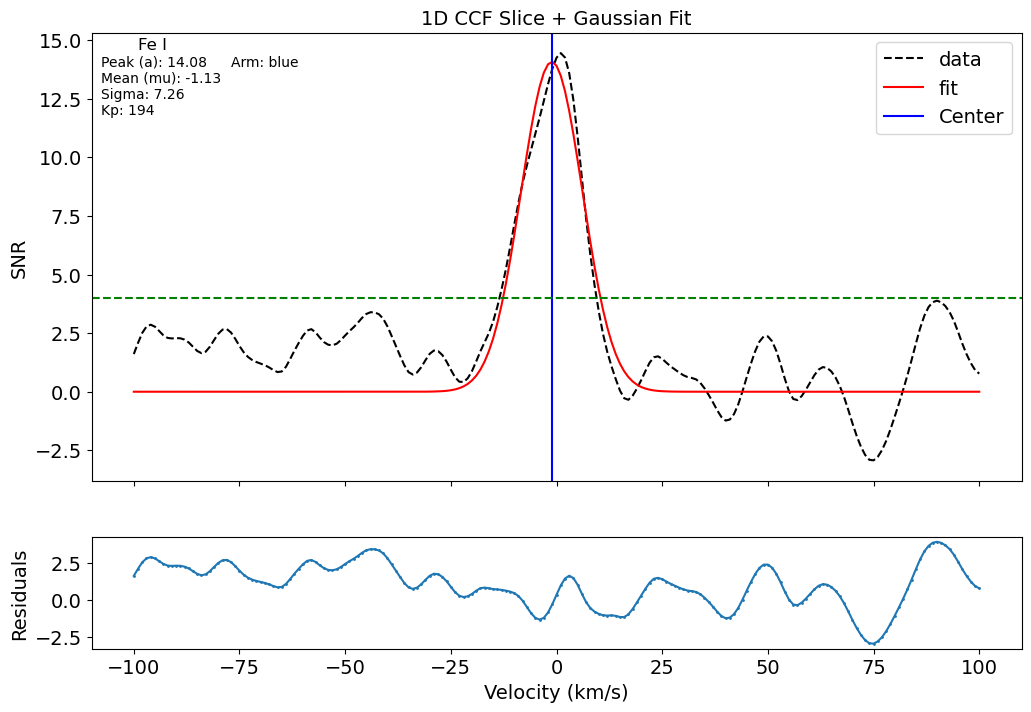

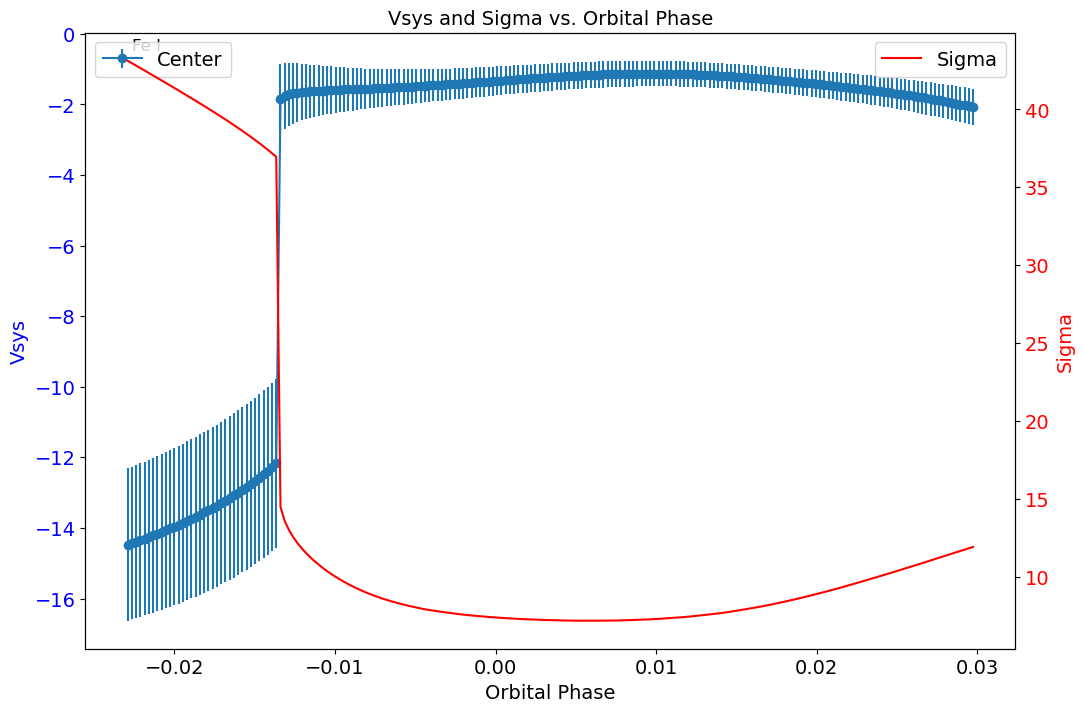

<Figure size 700x700 with 0 Axes>

Now running the  red  data for  20190504
The maximum total SNR is  7744.3228985129235


/home/calder/Documents/atmo-analysis-main/run_all_ccfs.py:1063: RuntimeWarning: divide by zero encountered in divide
  eof = corrected_error[:,this_one[s]]/corrected_flux[:,this_one[s]]
/home/calder/Documents/atmo-analysis-main/run_all_ccfs.py:1081: RuntimeWarning: divide by zero encountered in divide
  eof = corrected_error[ep,this_one]/corrected_flux[ep,this_one]
/home/calder/Documents/atmo-analysis-main/horus.py:297: RuntimeWarning: invalid value encountered in sqrt
  yp11=np.sqrt(rplanet[obj]**2-(xstar-center1[0])**2)
/home/calder/Documents/atmo-analysis-main/horus.py:303: RuntimeWarning: invalid value encountered in sqrt
  yp21=np.sqrt((rplanet[obj])**2-(xstar-center2[0])**2)


Selected SNR: 4.598404916358284 
 Selected Vsys: -2.7010725548537478 
 Selected sigma: 6.02149956379024 
 Selected Kp: 175


/tmp/ipykernel_44441/2263497278.py:163: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<Figure size 700x250 with 0 Axes>

<Figure size 700x700 with 0 Axes>

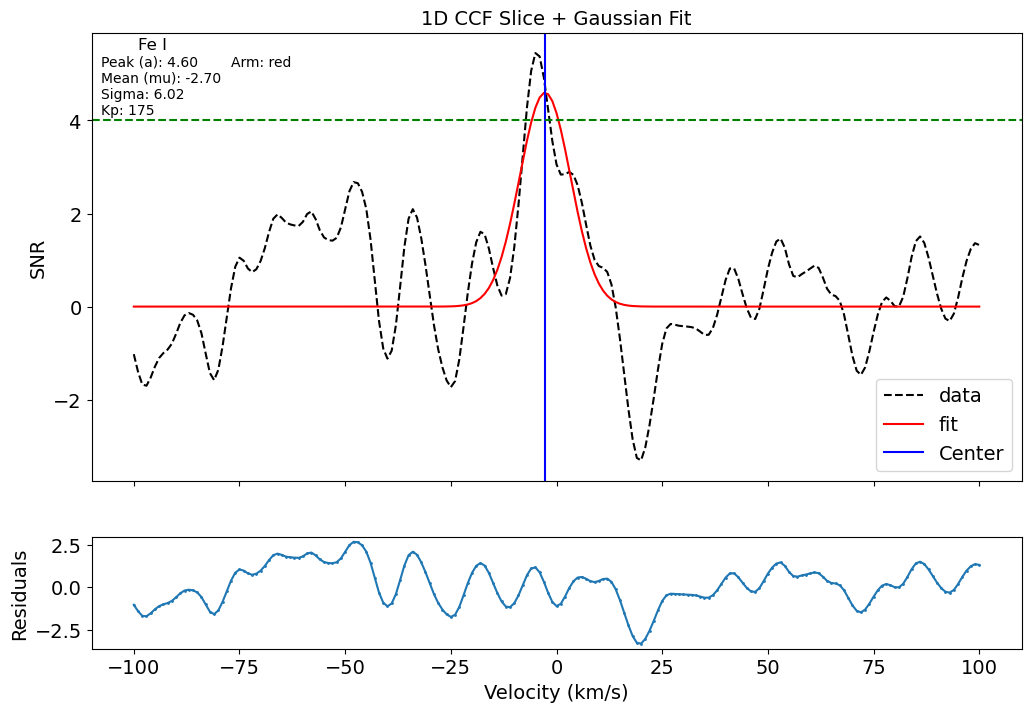

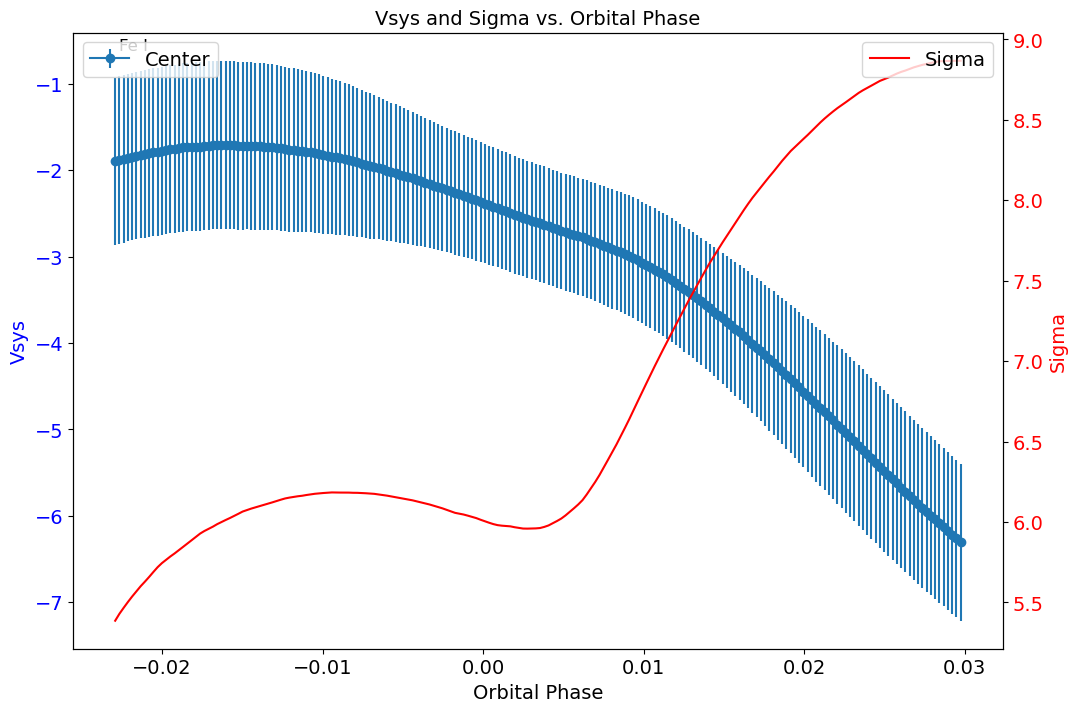

<Figure size 700x700 with 0 Axes>

Now combining all of the data


<Figure size 700x700 with 0 Axes>

In [21]:
run_all_ccfs.make_shifted_plot = make_shifted_plot
run_all_ccfs('KELT-20b', 'inverted-transmission-better', 'Fe I', 5.39e-05, False, True, True, 'ccf')

## Gaussian Fits on 1D CCF Slices of red and blue arms of Ni I

/home/calder/miniconda3/envs/exoplanets/lib/python3.11/site-packages/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of Ni...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



/home/calder/Documents/atmo-analysis-main/run_all_ccfs.py:680: RuntimeWarning: invalid value encountered in sqrt
  kernel = 1. / (np.pi * np.sqrt(1. - velocities**2 / profile_width**2))


Now running the  blue  data for  20190504
The maximum total SNR is  1420.901987322645


/home/calder/Documents/atmo-analysis-main/horus.py:297: RuntimeWarning: invalid value encountered in sqrt
  yp11=np.sqrt(rplanet[obj]**2-(xstar-center1[0])**2)
/home/calder/Documents/atmo-analysis-main/horus.py:303: RuntimeWarning: invalid value encountered in sqrt
  yp21=np.sqrt((rplanet[obj])**2-(xstar-center2[0])**2)
/home/calder/miniconda3/envs/exoplanets/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Selected SNR: 2.9484718336049514 
 Selected Vsys: 0.07148349685416444 
 Selected sigma: 4.339665419549832 
 Selected Kp: 98


/tmp/ipykernel_44441/2263497278.py:163: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<Figure size 640x480 with 0 Axes>

<Figure size 700x250 with 0 Axes>

<Figure size 700x700 with 0 Axes>

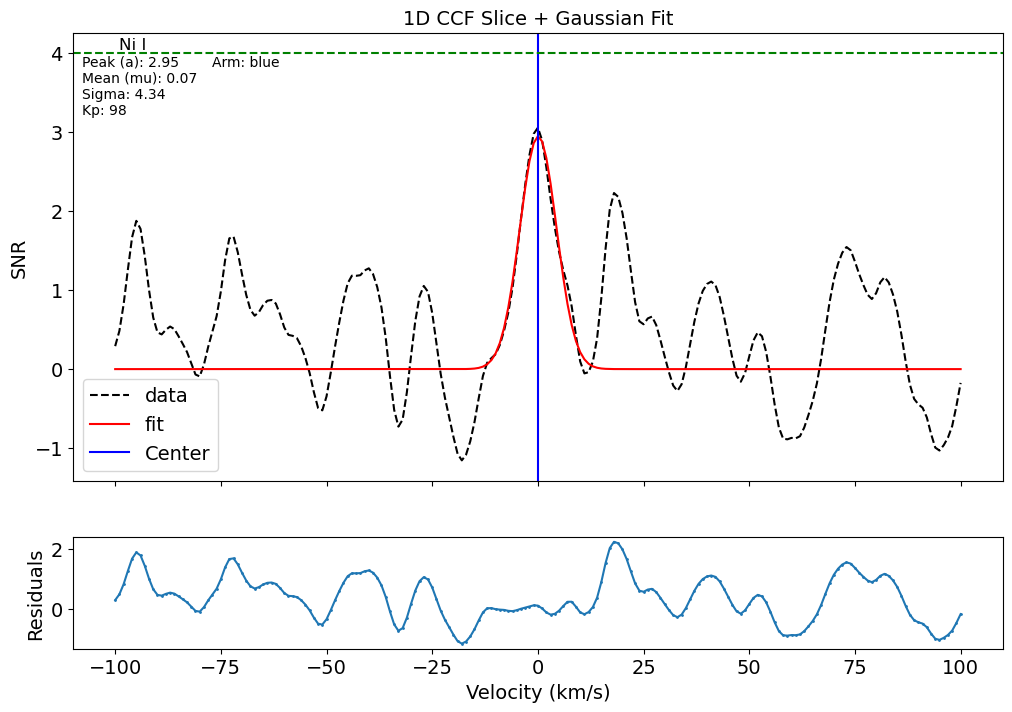

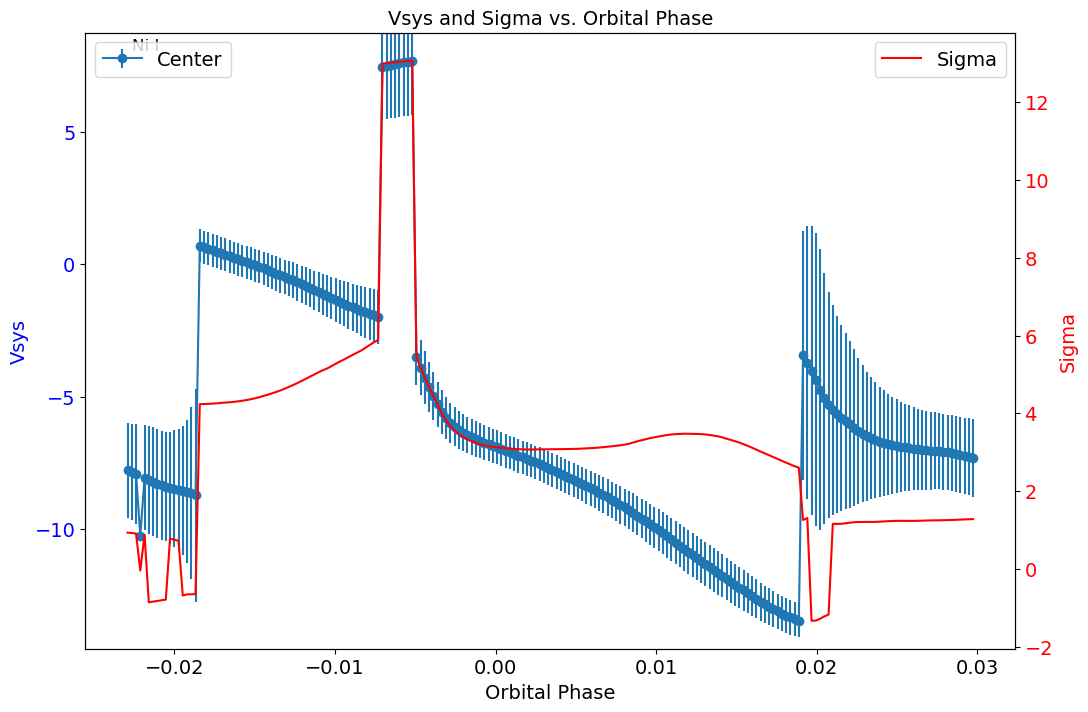

<Figure size 700x700 with 0 Axes>

Now running the  red  data for  20190504
The maximum total SNR is  7744.3228985129235


/home/calder/Documents/atmo-analysis-main/run_all_ccfs.py:1063: RuntimeWarning: divide by zero encountered in divide
  eof = corrected_error[:,this_one[s]]/corrected_flux[:,this_one[s]]
/home/calder/Documents/atmo-analysis-main/run_all_ccfs.py:1081: RuntimeWarning: divide by zero encountered in divide
  eof = corrected_error[ep,this_one]/corrected_flux[ep,this_one]
/home/calder/Documents/atmo-analysis-main/horus.py:297: RuntimeWarning: invalid value encountered in sqrt
  yp11=np.sqrt(rplanet[obj]**2-(xstar-center1[0])**2)
/home/calder/Documents/atmo-analysis-main/horus.py:303: RuntimeWarning: invalid value encountered in sqrt
  yp21=np.sqrt((rplanet[obj])**2-(xstar-center2[0])**2)
/home/calder/miniconda3/envs/exoplanets/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Selected SNR: 3.98316870426856 
 Selected Vsys: -5.082537197217473 
 Selected sigma: 2.7683627235358386 
 Selected Kp: 254


/tmp/ipykernel_44441/2263497278.py:163: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<Figure size 700x250 with 0 Axes>

<Figure size 700x700 with 0 Axes>

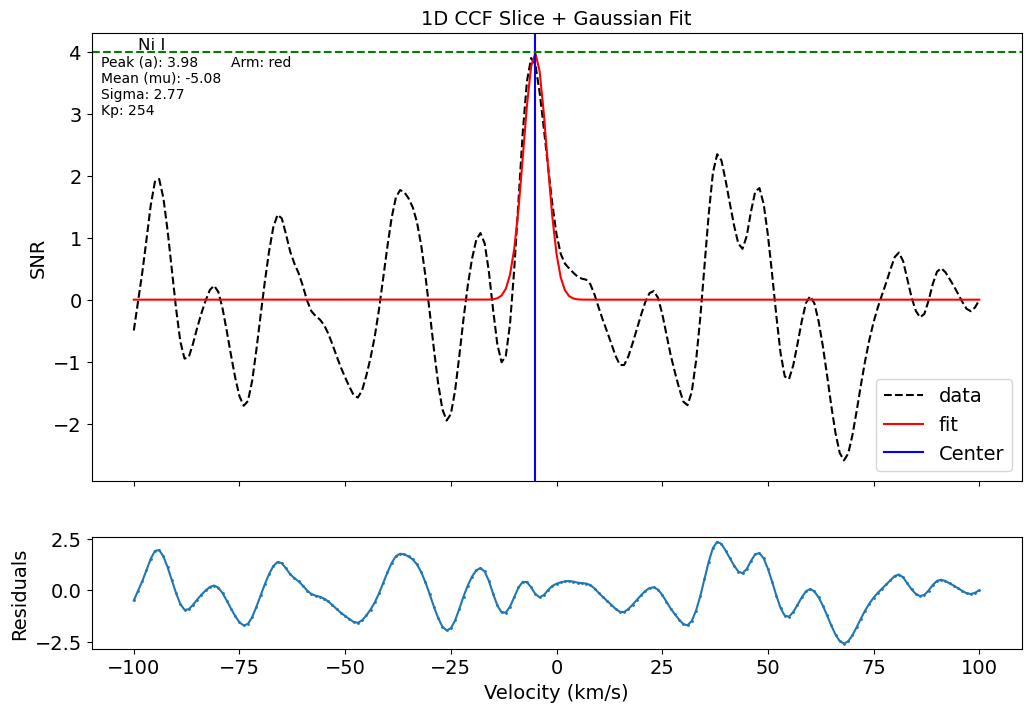

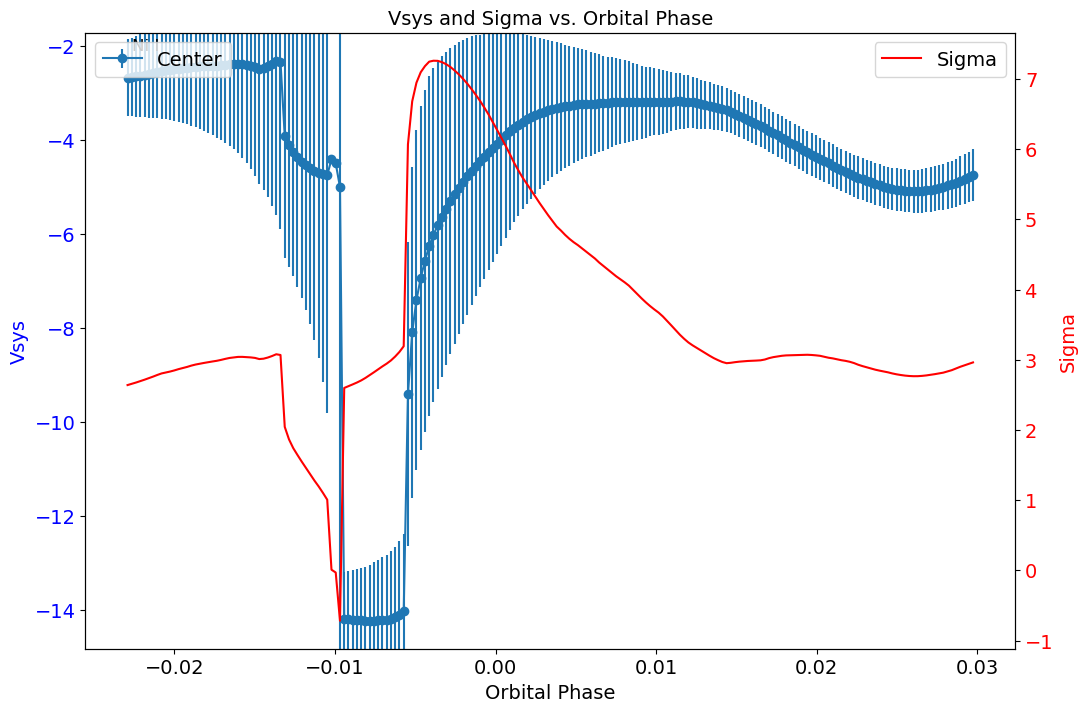

<Figure size 700x700 with 0 Axes>

Now combining all of the data


<Figure size 700x700 with 0 Axes>

In [22]:
run_all_ccfs('KELT-20b', 'inverted-transmission-better', 'Ni I', 2.67e-06, False, True, True, 'ccf')

## Gaussian Fits of 1D Slices of red and blue arms of V I

/home/calder/miniconda3/envs/exoplanets/lib/python3.11/site-packages/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of V...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



/home/calder/Documents/atmo-analysis-main/run_all_ccfs.py:680: RuntimeWarning: invalid value encountered in sqrt
  kernel = 1. / (np.pi * np.sqrt(1. - velocities**2 / profile_width**2))


Now running the  blue  data for  20190504
The maximum total SNR is  1420.901987322645


/home/calder/Documents/atmo-analysis-main/horus.py:297: RuntimeWarning: invalid value encountered in sqrt
  yp11=np.sqrt(rplanet[obj]**2-(xstar-center1[0])**2)
/home/calder/Documents/atmo-analysis-main/horus.py:303: RuntimeWarning: invalid value encountered in sqrt
  yp21=np.sqrt((rplanet[obj])**2-(xstar-center2[0])**2)


Selected SNR: 2.792328221361996 
 Selected Vsys: -3.2177076081421867 
 Selected sigma: 2.683636617276896 
 Selected Kp: 211


/tmp/ipykernel_44441/2263497278.py:163: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<Figure size 640x480 with 0 Axes>

<Figure size 700x250 with 0 Axes>

<Figure size 700x700 with 0 Axes>

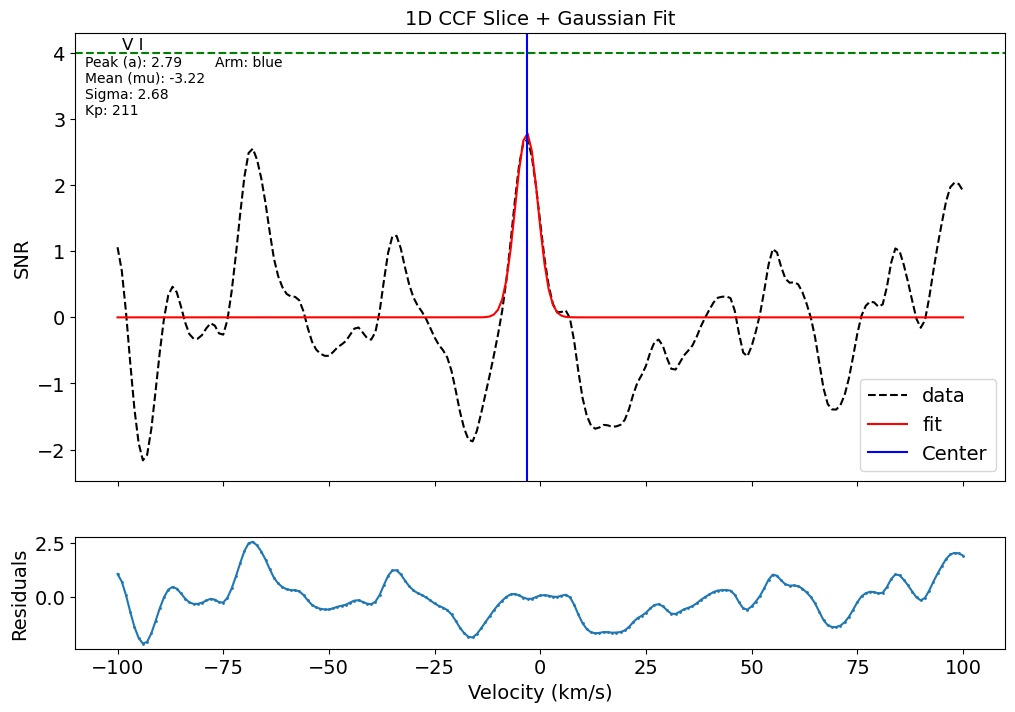

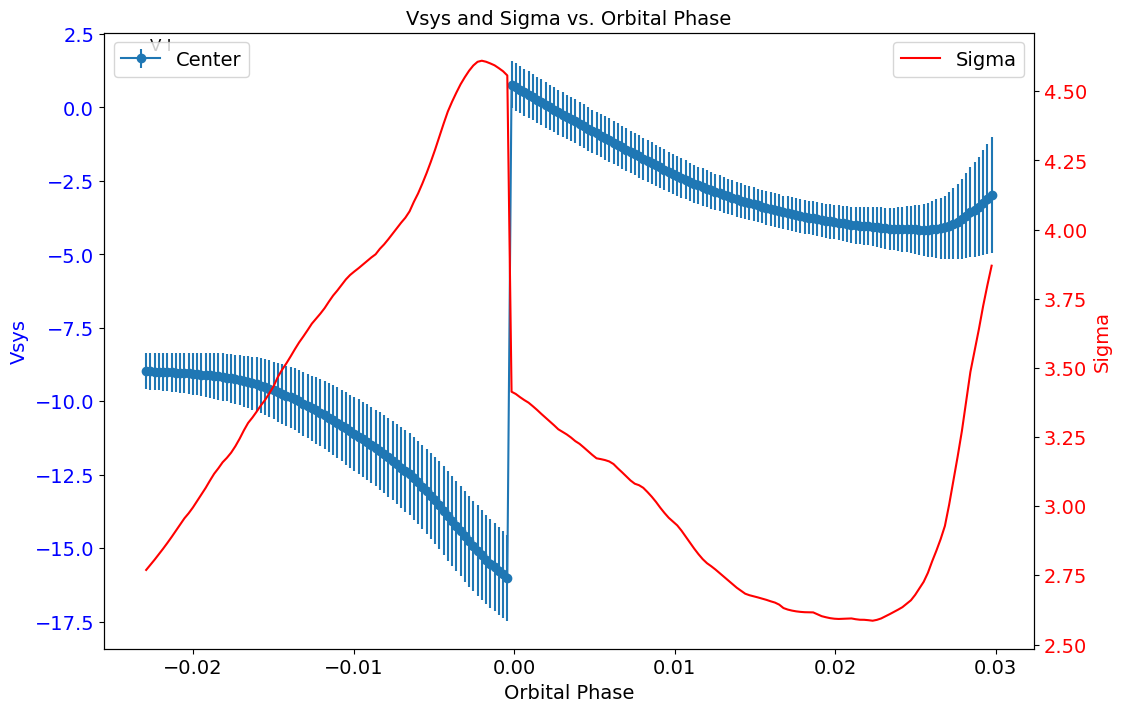

<Figure size 700x700 with 0 Axes>

Now running the  red  data for  20190504
The maximum total SNR is  7744.3228985129235


/home/calder/Documents/atmo-analysis-main/run_all_ccfs.py:1063: RuntimeWarning: divide by zero encountered in divide
  eof = corrected_error[:,this_one[s]]/corrected_flux[:,this_one[s]]
/home/calder/Documents/atmo-analysis-main/run_all_ccfs.py:1081: RuntimeWarning: divide by zero encountered in divide
  eof = corrected_error[ep,this_one]/corrected_flux[ep,this_one]
/home/calder/Documents/atmo-analysis-main/horus.py:297: RuntimeWarning: invalid value encountered in sqrt
  yp11=np.sqrt(rplanet[obj]**2-(xstar-center1[0])**2)
/home/calder/Documents/atmo-analysis-main/horus.py:303: RuntimeWarning: invalid value encountered in sqrt
  yp21=np.sqrt((rplanet[obj])**2-(xstar-center2[0])**2)


Selected SNR: 1.3954874008731375 
 Selected Vsys: -5.503833037122001 
 Selected sigma: 2.680200727836069 
 Selected Kp: 269


/tmp/ipykernel_44441/2263497278.py:163: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<Figure size 700x250 with 0 Axes>

<Figure size 700x700 with 0 Axes>

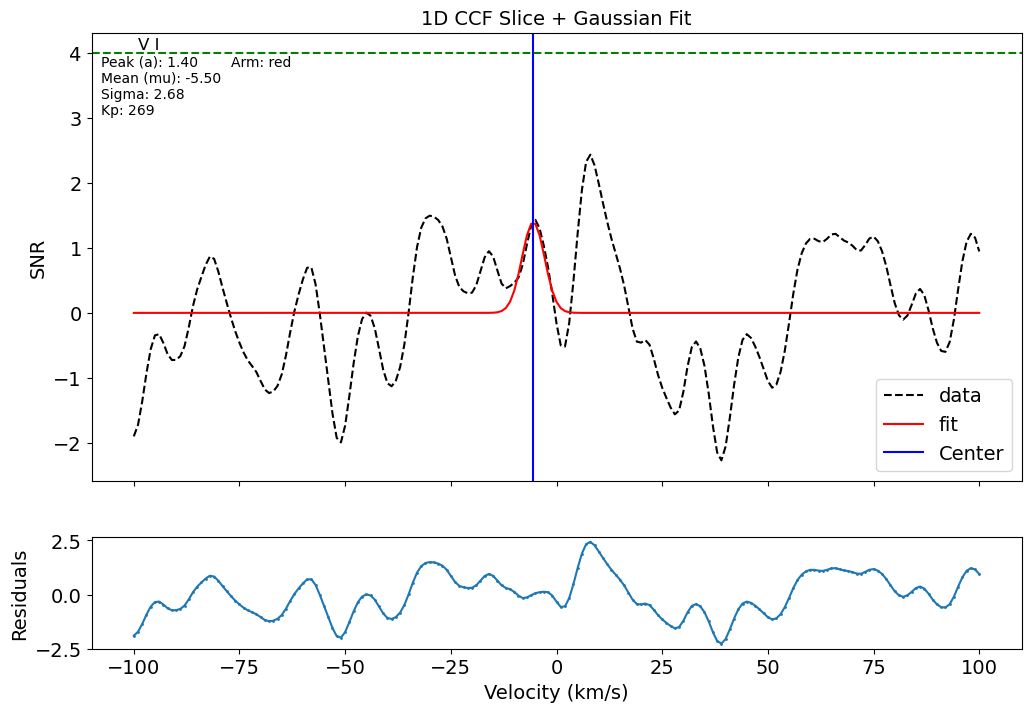

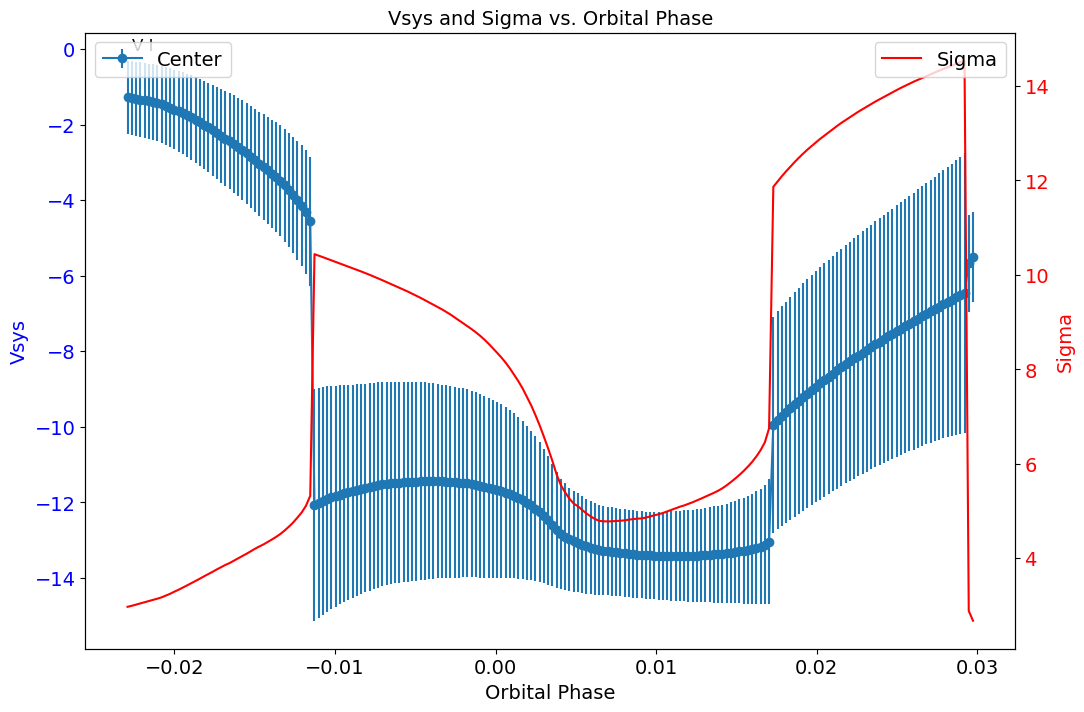

<Figure size 700x700 with 0 Axes>

Now combining all of the data


<Figure size 700x700 with 0 Axes>

In [23]:
run_all_ccfs('KELT-20b', 'inverted-transmission-better', 'V I', 5.632e-09, False, True, True, 'ccf')

## Gaussian fits of 1D slices of red and blue arms of Ca I

/home/calder/miniconda3/envs/exoplanets/lib/python3.11/site-packages/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of Ca...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



/home/calder/Documents/atmo-analysis-main/run_all_ccfs.py:680: RuntimeWarning: invalid value encountered in sqrt
  kernel = 1. / (np.pi * np.sqrt(1. - velocities**2 / profile_width**2))


Now running the  blue  data for  20190504
The maximum total SNR is  1420.901987322645


/home/calder/Documents/atmo-analysis-main/horus.py:297: RuntimeWarning: invalid value encountered in sqrt
  yp11=np.sqrt(rplanet[obj]**2-(xstar-center1[0])**2)
/home/calder/Documents/atmo-analysis-main/horus.py:303: RuntimeWarning: invalid value encountered in sqrt
  yp21=np.sqrt((rplanet[obj])**2-(xstar-center2[0])**2)
/home/calder/miniconda3/envs/exoplanets/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Selected SNR: 3.429060340249697 
 Selected Vsys: 0.5905971139030122 
 Selected sigma: 4.616132507240095 
 Selected Kp: 131


/tmp/ipykernel_44441/2263497278.py:163: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<Figure size 640x480 with 0 Axes>

<Figure size 700x250 with 0 Axes>

<Figure size 700x700 with 0 Axes>

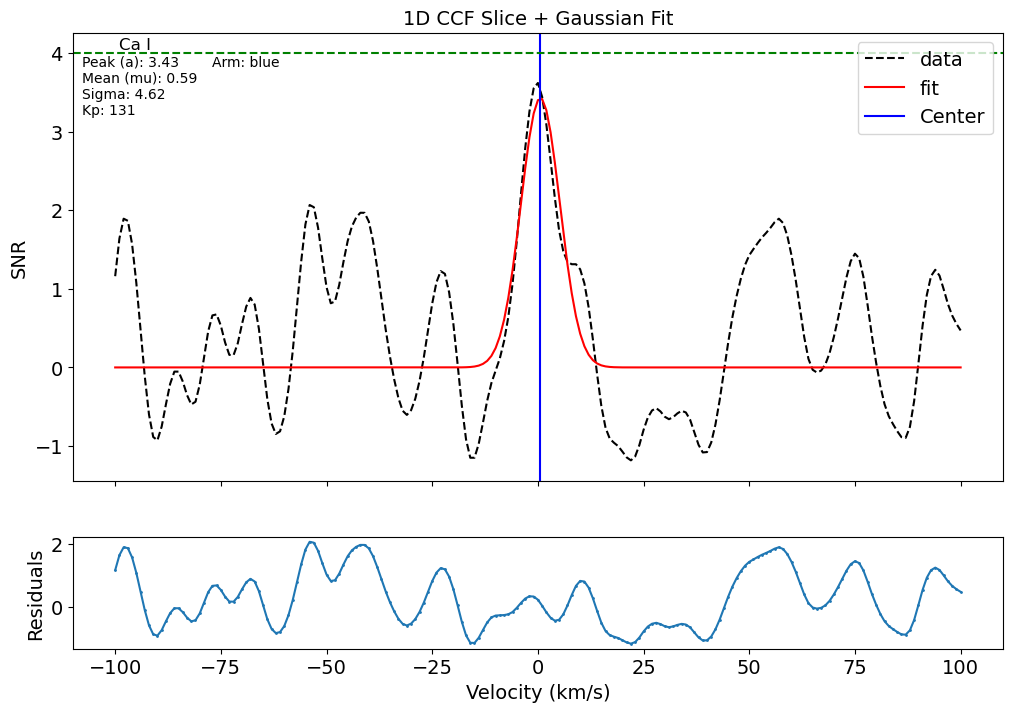

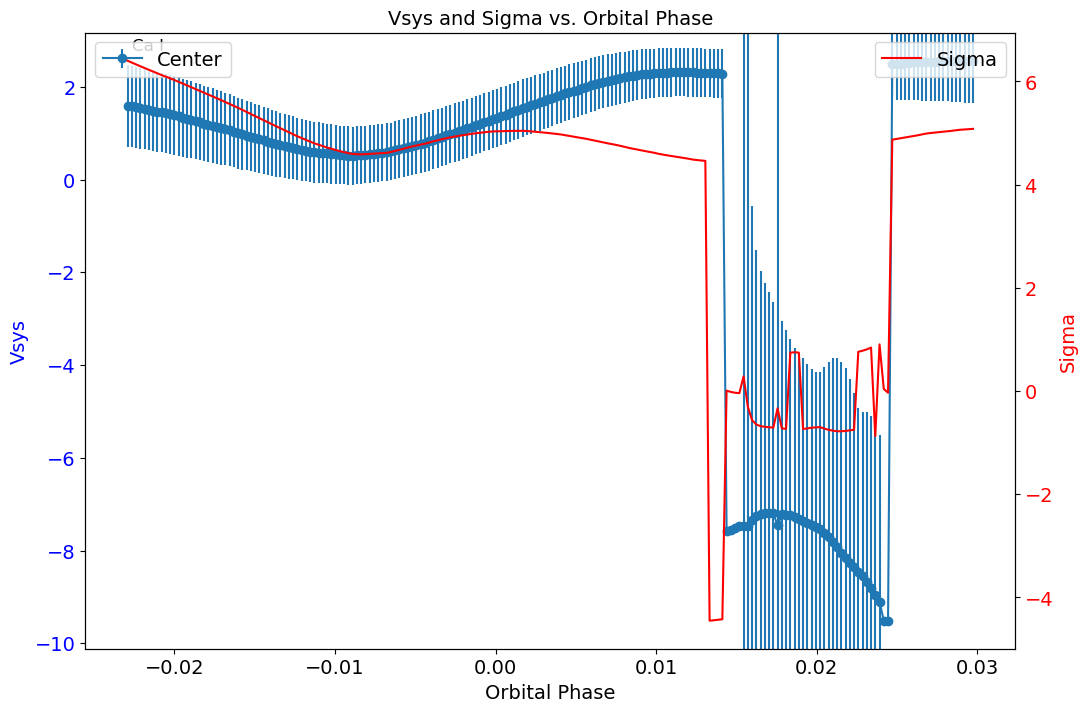

<Figure size 700x700 with 0 Axes>

Now running the  red  data for  20190504
The maximum total SNR is  7744.3228985129235


/home/calder/Documents/atmo-analysis-main/run_all_ccfs.py:1063: RuntimeWarning: divide by zero encountered in divide
  eof = corrected_error[:,this_one[s]]/corrected_flux[:,this_one[s]]
/home/calder/Documents/atmo-analysis-main/run_all_ccfs.py:1081: RuntimeWarning: divide by zero encountered in divide
  eof = corrected_error[ep,this_one]/corrected_flux[ep,this_one]
/home/calder/Documents/atmo-analysis-main/horus.py:297: RuntimeWarning: invalid value encountered in sqrt
  yp11=np.sqrt(rplanet[obj]**2-(xstar-center1[0])**2)
/home/calder/Documents/atmo-analysis-main/horus.py:303: RuntimeWarning: invalid value encountered in sqrt
  yp21=np.sqrt((rplanet[obj])**2-(xstar-center2[0])**2)


Selected SNR: 4.449790804859396 
 Selected Vsys: 0.4745748531592612 
 Selected sigma: 4.6292012925021115 
 Selected Kp: 167


/tmp/ipykernel_44441/2263497278.py:163: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<Figure size 700x250 with 0 Axes>

<Figure size 700x700 with 0 Axes>

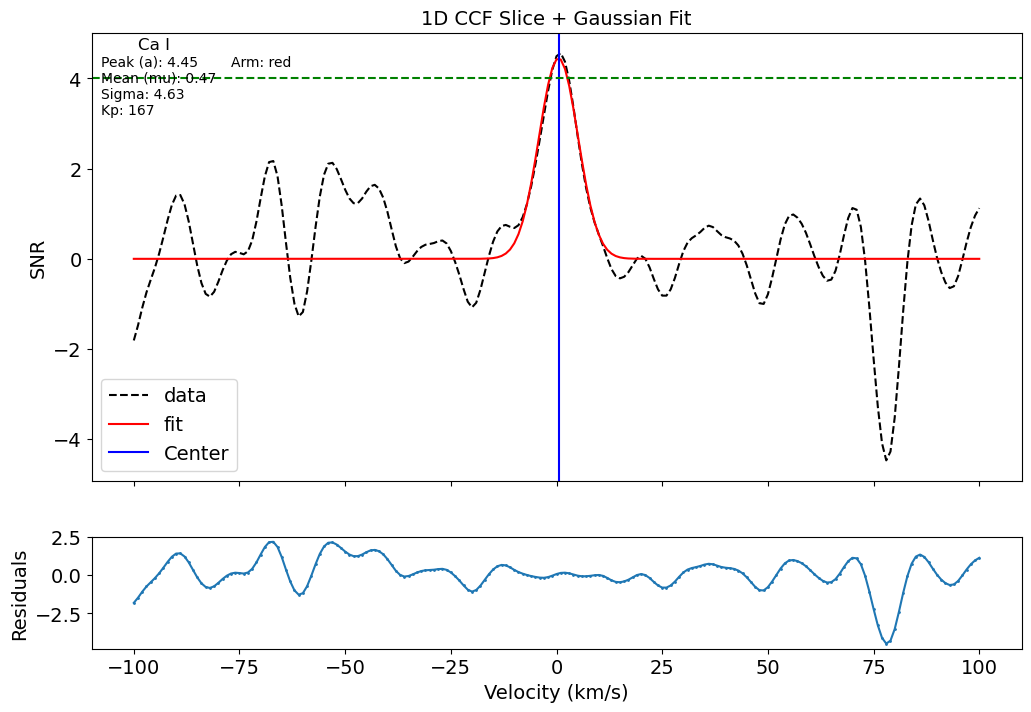

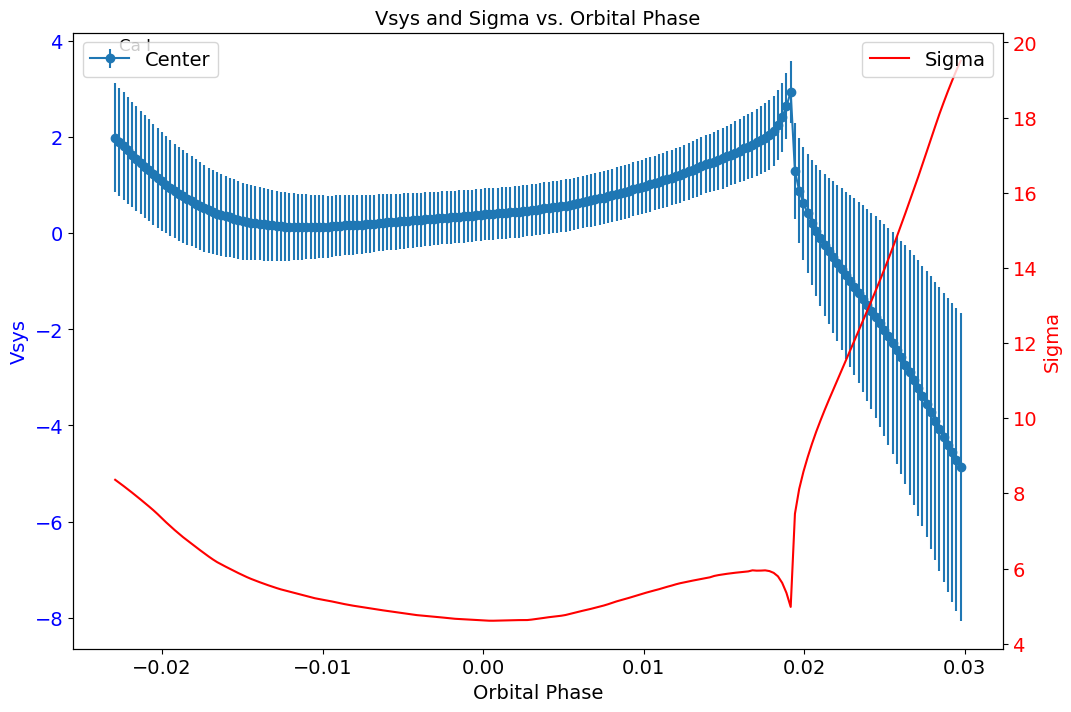

<Figure size 700x700 with 0 Axes>

Now combining all of the data


<Figure size 700x700 with 0 Axes>

In [24]:
run_all_ccfs('KELT-20b', 'inverted-transmission-better', 'Ca I', 2.101e-08, False, True, True, 'ccf')

## Gaussian fits of 1D slices of red and blue arms of TiO